# Retrieval metrics with different embeddings, before keypoints
- flags
- positions
- positions + angles + ratio
- positions normalized
- positions normalized + angles + ratio

**Load the dataset**

In [1]:
%load_ext autoreload
%autoreload 2

from libraries.embeddings_utils import *
import ipynbname
from libraries.classifier_utils import *
from libraries.retrieval_utils import *
from libraries.file_manager_utils import *

project_dir = f"{os.getcwd().split('SIDS_revelation_project')[0]}SIDS_revelation_project/"
image_dataset_path = f"{project_dir}datasets/onback_onstomach_v3"
model_path = f"{project_dir}/models/4.fd_weights/best.pt"

In [2]:
emb_builder = EmbeddingBuilder(model_path, image_dataset_path, "load")


Extracting dataset info from .coco.json file:---------------------------------------------
Dataset contains 4158 valid samples, and labels are {'baby_on_back': 1, 'baby_on_stomach': 2}
------------------------------------------------------------------------------------------

Loading features from .csv----------------------------------------------------------------
Features loaded succesfully, in particular there are 4158 files in the dataset
------------------------------------------------------------------------------------------

Embedding builder initialized successfully------------------------------------------------
Face detection model: 4 (YOLOv8)
Dataset: /Users/lorenzodimaio/Download/SIDS_revelation_project/datasets/onback_onstomach_v3
Dataset dimension: 4158
Dataset labels: {'baby_safe': 0, 'baby_unsafe': 1}
------------------------------------------------------------------------------------------


In [141]:
print(f"Dataset contains {emb_builder.dim_dataset} elements.\nIn particular {emb_builder.dim_dataset-emb_builder.y.sum()} {'baby_safe' if emb_builder.classes_bs['baby_safe'] == 0 else 'baby_unsafe'} and {emb_builder.y.sum()} {'baby_safe' if emb_builder.classes_bs['baby_safe'] == 1 else 'baby_unsafe'}")

Dataset contains 4158 elements.
In particular 2146 baby_safe and 2012 baby_unsafe


**Create embeddings**

In [142]:
e_flags = emb_builder.create_embedding(flags = True)
e_positions = emb_builder.create_embedding(flags = True, positions=True)
e_positions_norm = emb_builder.create_embedding(flags = True, positions_normalized=True)
e_all_unnorm = emb_builder.create_embedding(flags = True, positions=True, geometric_info=True)
e_all_norm = emb_builder.create_embedding(flags = True, positions_normalized = True, geometric_info=True)
e_all = emb_builder.create_embedding(flags = True, positions = True, positions_normalized=True, geometric_info=True)


Embedding creation------------------------------------------------------------------------
Features: ['flag_eye1', 'flag_eye2', 'flag_nose', 'flag_mouth']
FINISHED: 4158 embedding created
------------------------------------------------------------------------------------------

Embedding creation------------------------------------------------------------------------
Features: ['flag_eye1', 'flag_eye2', 'flag_nose', 'flag_mouth', 'x_eye1', 'y_eye1', 'x_eye2', 'y_eye2', 'x_nose', 'y_nose', 'x_mouth', 'y_mouth']
FINISHED: 4158 embedding created
------------------------------------------------------------------------------------------

Embedding creation------------------------------------------------------------------------
Features: ['flag_eye1', 'flag_eye2', 'flag_nose', 'flag_mouth', 'x_eye1_norm', 'y_eye1_norm', 'x_eye2_norm', 'y_eye2_norm', 'x_nose_norm', 'y_nose_norm', 'x_mouth_norm', 'y_mouth_norm']
FINISHED: 4158 embedding created
-----------------------------------------------

**Initialize retrieval objects**

In [143]:
embeddings = [e_flags, e_positions, e_positions_norm, e_all_unnorm, e_all_norm, e_all]
embeddings_names = ["Flags", "Positions", "Positions Norm", "All Unnorm", "All Norm", "All features"]

retrieval_euclidean = { name: ImageRetrieval(emb, emb_builder.y, emb_builder.image_paths, image_dataset_path, emb_builder.classes_bs)
                        for name, emb  in zip(embeddings_names, embeddings)}
retrieval_cosine = { name: ImageRetrieval(emb, emb_builder.y, emb_builder.image_paths, image_dataset_path, emb_builder.classes_bs)
                        for name, emb  in zip(embeddings_names, embeddings)}
retrieval_mahalanobis = { name: ImageRetrieval(emb, emb_builder.y, emb_builder.image_paths, image_dataset_path, emb_builder.classes_bs)
                        for name, emb  in zip(embeddings_names, embeddings)}

In [144]:
for name, retrieval in retrieval_euclidean.items():
    retrieval.build_index(metric="euclidean")

for name, retrieval in retrieval_cosine.items():
    retrieval.build_index(metric="cosine")

for name, retrieval in retrieval_mahalanobis.items():
    retrieval.build_mahalanobis_index()

**Evaluate precison, recall@R and silhouette scores**

In [72]:
k_values = [5, 10, 20, 50]
precision_scores_euclidean = {name: retrieval.plot_precision_at_k(k_values=k_values, verbose=False)
                              for name, retrieval in retrieval_euclidean.items()}
precision_scores_cosine = {name: retrieval.plot_precision_at_k(k_values=k_values, verbose=False)
                              for name, retrieval in retrieval_cosine.items()}
precision_scores_mahalanobis = {name: retrieval.plot_precision_at_k(k_values=k_values, verbose=False)
                              for name, retrieval in retrieval_mahalanobis.items()}
print("Precision scores evaluated successfully!")

Precision scores evaluated successfully!


In [73]:
silhouette_scores_euclidean = {name: retrieval.plot_silhouette_per_class()
                              for name, retrieval in retrieval_euclidean.items()}
silhouette_scores_cosine = {name: retrieval.plot_silhouette_per_class()
                              for name, retrieval in retrieval_cosine.items()}
silhouette_scores_mahalanobis = {name: retrieval.plot_silhouette_per_class()
                              for name, retrieval in retrieval_mahalanobis.items()}
print("Silhouette scores evaluated successfully!")

Silhouette scores evaluated successfully!


In [74]:
recall_scores_euclidean = {name: retrieval.recall_at_R()
                              for name, retrieval in retrieval_euclidean.items()}
recall_scores_cosine = {name: retrieval.recall_at_R()
                              for name, retrieval in retrieval_cosine.items()}
recall_scores_mahalanobis = {name: retrieval.recall_at_R()
                              for name, retrieval in retrieval_mahalanobis.items()}
print("Recall@R scores evaluated successfully!")

Recall@R scores evaluated successfully!


**Compare embeddings according to scores (scores evaluated with three different metrics)**

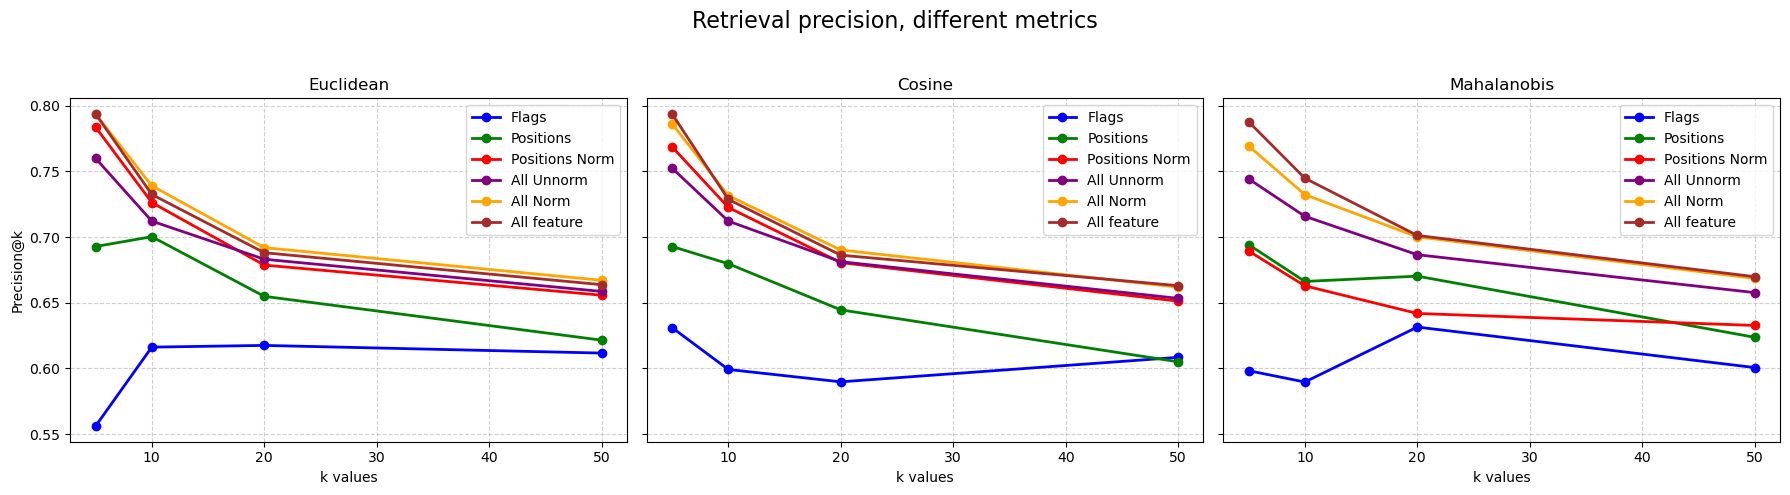

In [76]:
import matplotlib.pyplot as plt
figsize = (18, 5)

fig, axes = plt.subplots(1, 3, figsize=figsize, sharey=True)

metrics = ["Euclidean", "Cosine", "Mahalanobis"]
all_scores = [precision_scores_euclidean, precision_scores_cosine, precision_scores_mahalanobis]
colors = ["blue", "green", "red", "purple", "orange", "brown"]

for ax, metric, scores in zip(axes, metrics, all_scores):
    for score, label, color in zip(scores.values(), scores.keys(), colors):
        ax.plot(k_values, score, marker="o", color=color, linewidth=2, label=label)
    ax.set_title(metric)
    ax.set_xlabel("k values")
    ax.grid(True, linestyle="--", alpha=0.6)
    if ax == axes[0]:
        ax.set_ylabel("Precision@k")
    ax.legend()

plt.suptitle("Retrieval precision, different metrics", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

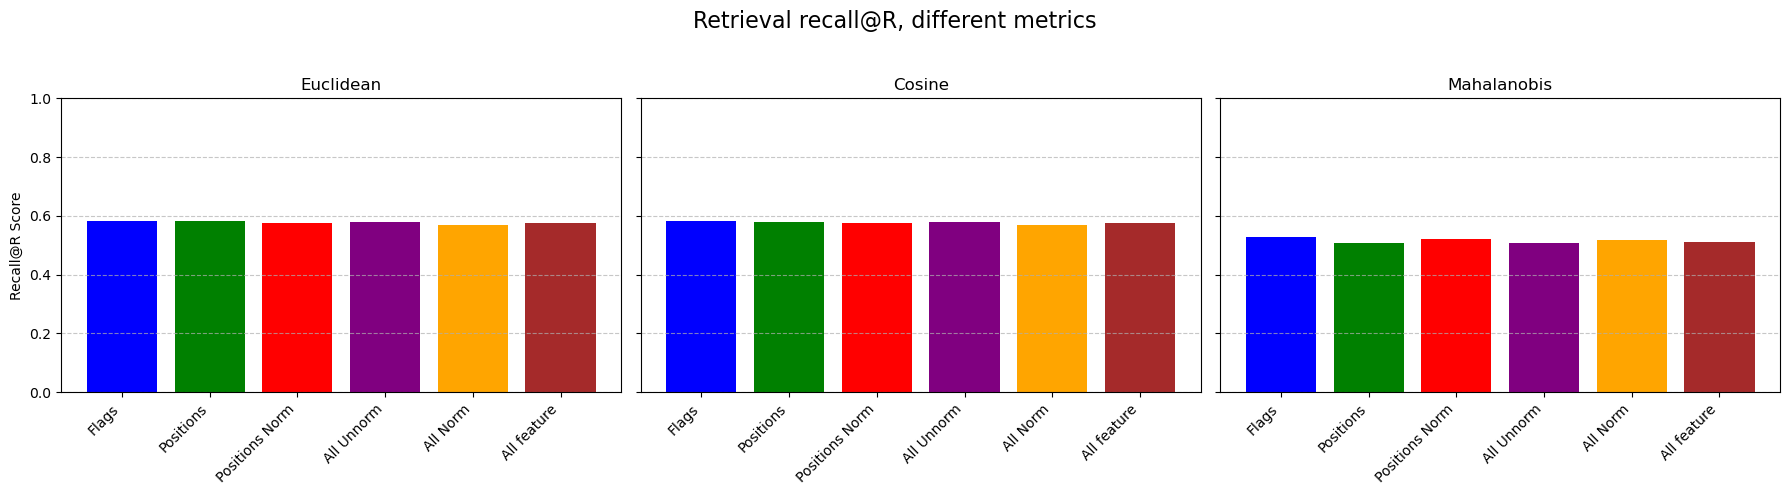

In [77]:
figsize = (18, 5)
fig, axes = plt.subplots(1, 3, figsize=figsize, sharey=True)

metrics = ["Euclidean", "Cosine", "Mahalanobis"]
all_scores = [recall_scores_euclidean, recall_scores_cosine, recall_scores_mahalanobis]
colors = ["blue", "green", "red", "purple", "orange", "brown"]

for ax, metric, scores in zip(axes, metrics, all_scores):
    ax.bar(scores.keys(), scores.values(), color=colors[:len(scores)])
    ax.set_title(metric)
    ax.set_ylabel("Recall@R Score" if ax == axes[0] else "")
    ax.set_xticklabels(scores.keys(), rotation=45, ha="right")
    ax.set_ylim(0, 1)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.suptitle("Retrieval recall@R, different metrics", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


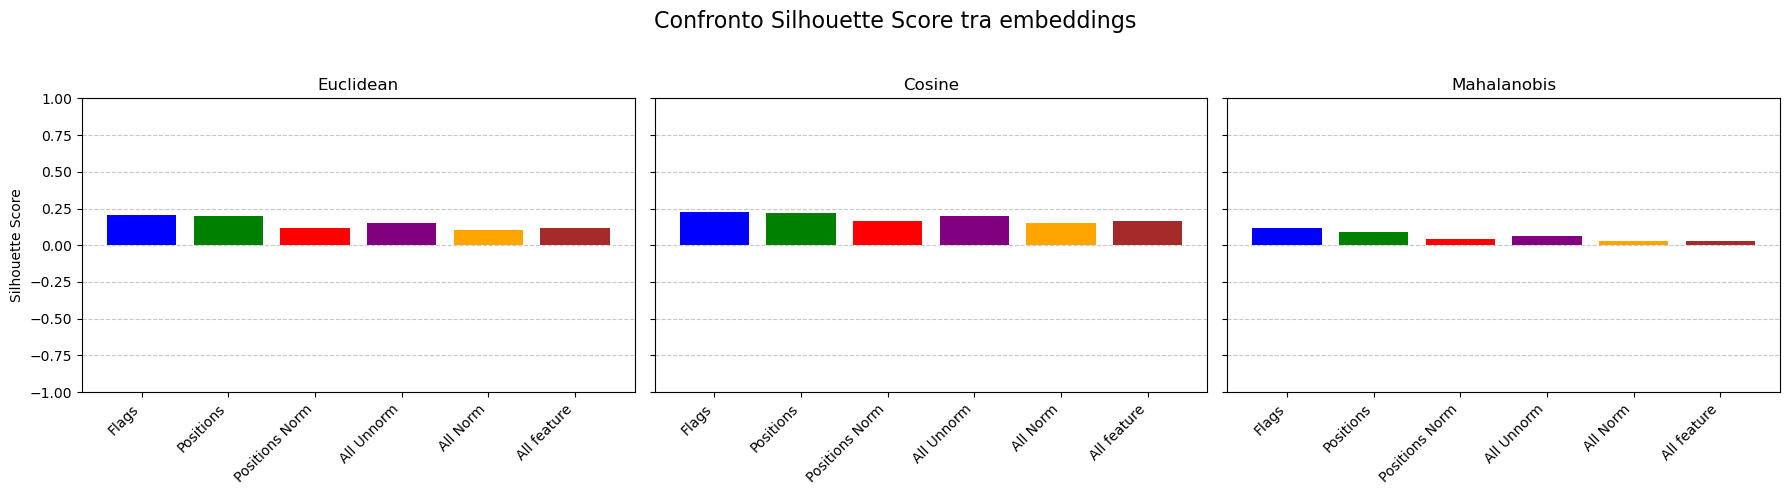

In [78]:
figsize = (18, 5)
fig, axes = plt.subplots(1, 3, figsize=figsize, sharey=True)

metrics = ["Euclidean", "Cosine", "Mahalanobis"]
all_scores = [silhouette_scores_euclidean, silhouette_scores_cosine, silhouette_scores_mahalanobis]
colors = ["blue", "green", "red", "purple", "orange", "brown"]

for ax, metric, scores in zip(axes, metrics, all_scores):
    ax.bar(scores.keys(), scores.values(), color=colors[:len(scores)])
    ax.set_title(metric)
    ax.set_ylabel("Silhouette Score" if ax == axes[0] else "")
    ax.set_xticklabels(scores.keys(), rotation=45, ha="right")
    ax.set_ylim(-1, 1)  # Silhouette score range
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.suptitle("Confronto Silhouette Score tra embeddings", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


**Compare embeddings according to visual image similarity**

Image to retrieve


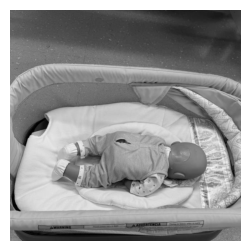

Flags-----------------------------------------------------------------------------------------------


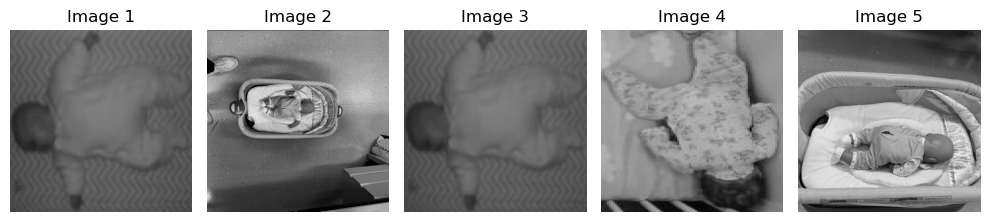

Positions-------------------------------------------------------------------------------------------


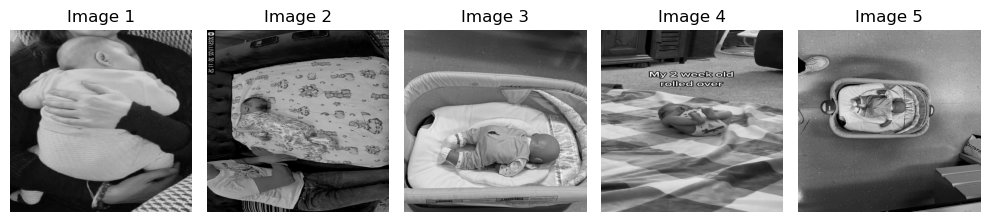

Positions Norm--------------------------------------------------------------------------------------


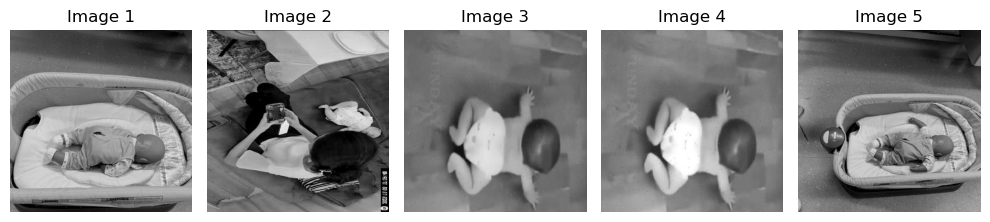

All Unnorm------------------------------------------------------------------------------------------


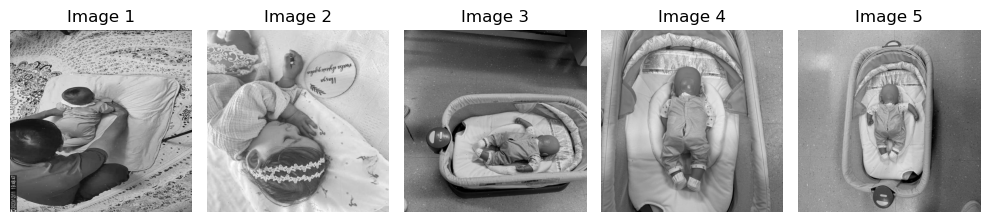

All Norm--------------------------------------------------------------------------------------------


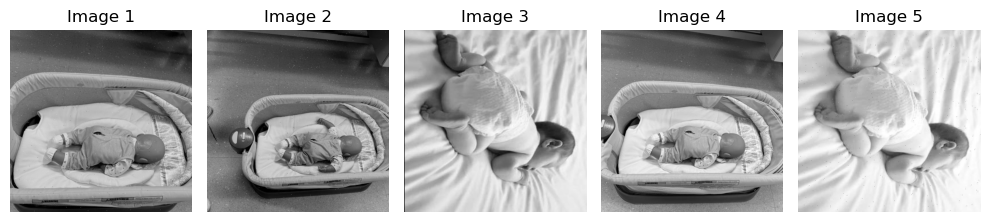

All features----------------------------------------------------------------------------------------


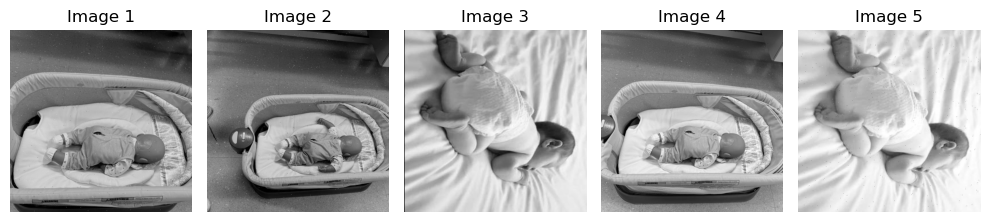

In [152]:
image_paths = emb_builder.image_paths
idx_query = 98
image_to_retrieve = image_paths[idx_query]

print("Image to retrieve")
img = mpimg.imread(image_to_retrieve)
plt.figure(figsize=(3, 3))
plt.imshow(img)
plt.axis('off')
plt.show()

for name, retrieval in retrieval_euclidean.items():
    print(f"{name}".ljust(100, "-"))
    distances_all, image_paths_similar_all = retrieval.retrieve_similar(idx_query=idx_query,k=5,verbose=False)
    retrieval.show_images(image_paths_similar_all)

**Classifier training with different embeddings**

In [101]:
embeddings_classifiers = {name : Classifier(emb, emb_builder.y, emb_builder.classes_bs) for name, emb in zip(embeddings_names, embeddings)}

In [102]:
clf = RandomForestClassifier(n_estimators=300,
                max_depth=8,              # limit tree depth
                min_samples_split=10,     # require more samples to split
                min_samples_leaf=5,       # require more samples per leaf
                max_features="sqrt",      # random feature selection
                bootstrap=True,
                random_state=42)

learning_scores = { name: classifier.plot_learning_curve(clf, verbose = False) for name, classifier in embeddings_classifiers.items()}
print("Learning scores evaluated successfully!")

Learning scores evaluated succesfully!


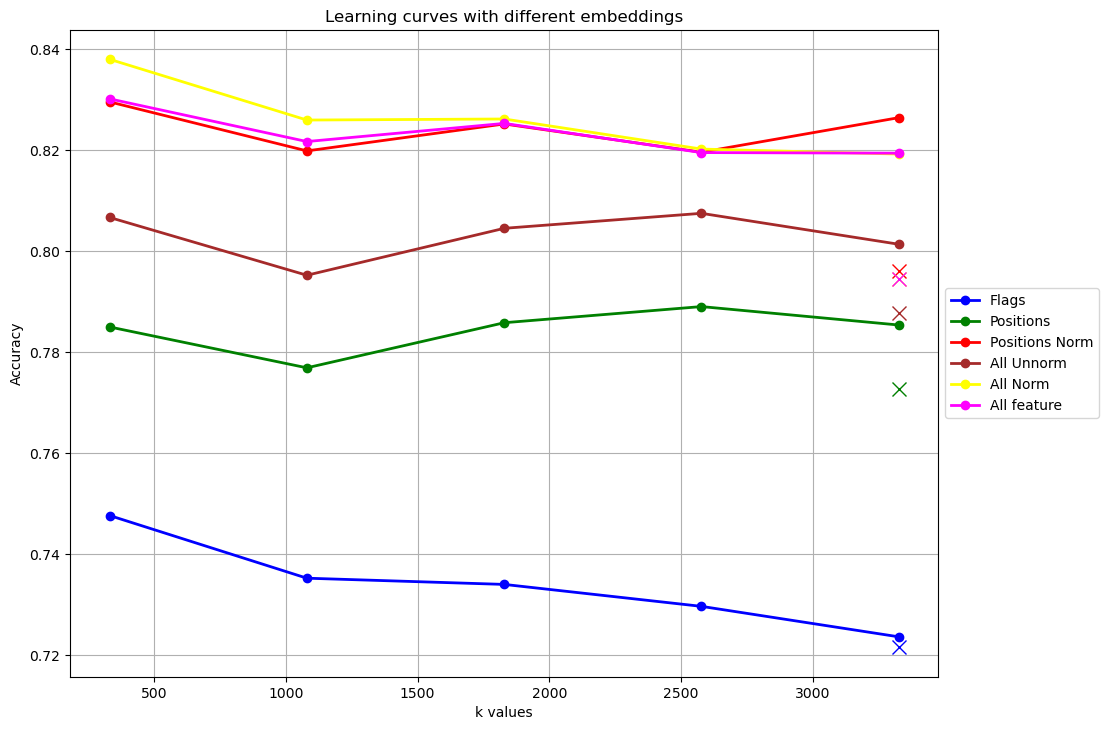

In [104]:
figsize = (embeddings_classifiers["Flags"].figsize[0]*2, embeddings_classifiers["Flags"].figsize[1]*2)
colors = ["blue", "green", "red", "brown", "yellow", "fuchsia"]

plt.figure(figsize=figsize)
for score, label, color in zip(learning_scores.values(), learning_scores.keys(), colors):
    plt.plot(score[0], score[3], marker="o", color=color, linewidth=2, label=label)
    #plt.plot(score[0], score[4], marker="o", color=color, linewidth=2, label=label) test curve
    plt.plot(score[0][len(score[0])-1], score[4][len(score[4])-1], marker="x",markersize = 10, color=color)

# Legenda
plt.legend(
    loc="center left",          # posizione di riferimento
    bbox_to_anchor=(1, 0.5),    # sposta la legenda a destra del grafico
    fontsize=10
)
plt.xlabel("k values")
plt.ylabel("Accuracy")
plt.title("Learning curves with different embeddings")
plt.grid(True)
plt.show()

# Retrieval metrics with different embeddings, with keypoints

- All Norm + k_positions_normalized
- All features (flags+positions+positions normalized + geometric) + k_positions_normalized
- Positions Norm (positions normalized) + k_geometric_info
- All features (flags+positions+positions normalized + geometric) + k_geometric_info
- Positions Norm (positions normalized) + k_geometric-info + k_positions_normalized
- All features (flags+positions+positions normalized + geometric) + k_geometric_info+k_geometric-info + k_positions_normalized


In [3]:
%load_ext autoreload
%autoreload 2

from libraries.embeddings_utils import *
import ipynbname
from libraries.classifier_utils import *
from libraries.retrieval_utils import *
from libraries.file_manager_utils import *


project_dir = f"{os.getcwd().split('SIDS_revelation_project')[0]}SIDS_revelation_project/"
image_dataset_path = f"{project_dir}datasets/onback_onstomach_v3"
model_path_fd = f"{project_dir}/models/4.fd_weights/best.pt"
model_path_pe=f"{project_dir}/models/2.pe_weights/best.pt"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
emb_builder = EmbeddingBuilder(model_path_fd, image_dataset_path, "load", model_path_pe)


Extracting dataset info from .coco.json file:---------------------------------------------
Dataset contains 4158 valid samples, and labels are {'baby_on_back': 1, 'baby_on_stomach': 2}
------------------------------------------------------------------------------------------

Loading features from .csv----------------------------------------------------------------
Features loaded succesfully, in particular there are 4158 files in the dataset
------------------------------------------------------------------------------------------

Embedding builder initialized successfully------------------------------------------------
Face detection model: 4 (YOLOv8)
Dataset: /Users/lorenzodimaio/Download/SIDS_revelation_project/datasets/onback_onstomach_v3
Dataset dimension: 4158
Dataset labels: {'baby_safe': 0, 'baby_unsafe': 1}
------------------------------------------------------------------------------------------


In [5]:
e_norm_positions= emb_builder.create_embedding(flags = True, positions_normalized=True, geometric_info=True, k_positions_normalized=True)
e_all_positions =emb_builder.create_embedding(flags = True, positions = True,positions_normalized=True, geometric_info=True, k_positions_normalized=True)

e_norm_geometric =emb_builder.create_embedding(flags = True, positions_normalized=True, geometric_info=True, k_geometric_info=True)
e_all_geometric = emb_builder.create_embedding(flags = True, positions = True,positions_normalized=True, geometric_info=True, k_geometric_info=True)

e_norm_all= emb_builder.create_embedding(flags = True, positions_normalized=True, geometric_info=True, k_positions_normalized=True, k_geometric_info=True)
e_all_all = emb_builder.create_embedding(flags = True, positions = True,positions_normalized=True, geometric_info=True, k_positions_normalized=True, k_geometric_info=True)




Embedding creation------------------------------------------------------------------------
Features: ['flag_eye1', 'flag_eye2', 'flag_nose', 'flag_mouth', 'x_eye1_norm', 'y_eye1_norm', 'x_eye2_norm', 'y_eye2_norm', 'x_nose_norm', 'y_nose_norm', 'x_mouth_norm', 'y_mouth_norm', 'eye_distance', 'eye_distance_norm', 'face_vertical_length', 'face_vertical_length_norm', 'face_angle_vertical', 'face_angle_horizontal', 'symmetry_diff', 'head_ration', 'x_nose_k', 'y_nose_k', 'x_left_eye_k', 'y_left_eye_k', 'x_right_eye_k', 'y_right_eye_k', 'x_left_ear', 'y_left_ear', 'x_right_ear', 'y_right_ear', 'x_left_shoulder', 'y_left_shoulder', 'x_right_shoulder', 'y_right_shoulder', 'x_left_elbow', 'y_left_elbow', 'x_right_elbow', 'y_right_elbow', 'x_left_wrist', 'y_left_wrist', 'x_right_wrist', 'y_right_wrist', 'x_left_hip', 'y_left_hip', 'x_right_hip', 'y_right_hip', 'x_left_knee', 'y_left_knee', 'x_right_knee', 'y_right_knee', 'x_left_ankle', 'y_left_ankle', 'x_right_ankle', 'y_right_ankle']
FINISHED

In [6]:
embeddings = [e_norm_positions, e_all_positions, e_norm_geometric, e_all_geometric, e_norm_all, e_all_all]
embeddings_names = ["All norm+k_positions", "All+k_positions", "All norm+k_geometric", "All+k_geometric", "All norm+all", "All+all"]

retrieval_euclidean = { name: ImageRetrieval(emb, emb_builder.y, emb_builder.image_paths, image_dataset_path, emb_builder.classes_bs)
                        for name, emb  in zip(embeddings_names, embeddings)}
retrieval_cosine = { name: ImageRetrieval(emb, emb_builder.y, emb_builder.image_paths, image_dataset_path, emb_builder.classes_bs)
                        for name, emb  in zip(embeddings_names, embeddings)}
retrieval_mahalanobis = { name: ImageRetrieval(emb, emb_builder.y, emb_builder.image_paths, image_dataset_path, emb_builder.classes_bs)
                        for name, emb  in zip(embeddings_names, embeddings)}

In [7]:
for name, retrieval in retrieval_euclidean.items():
    retrieval.build_index(metric="euclidean")

for name, retrieval in retrieval_cosine.items():
    retrieval.build_index(metric="cosine")

for name, retrieval in retrieval_mahalanobis.items():
    retrieval.build_mahalanobis_index()

**Evaluate precison, recall@R and silhouette scores**

In [8]:
k_values = [5, 10, 20, 50]
precision_scores_euclidean = {name: retrieval.plot_precision_at_k(k_values=k_values, verbose=False)
                              for name, retrieval in retrieval_euclidean.items()}
precision_scores_cosine = {name: retrieval.plot_precision_at_k(k_values=k_values, verbose=False)
                              for name, retrieval in retrieval_cosine.items()}
precision_scores_mahalanobis = {name: retrieval.plot_precision_at_k(k_values=k_values, verbose=False)
                              for name, retrieval in retrieval_mahalanobis.items()}
print("Precision scores evaluated successfully!")

Precision scores evaluated successfully!


In [9]:
silhouette_scores_euclidean = {name: retrieval.plot_silhouette_per_class()
                              for name, retrieval in retrieval_euclidean.items()}
print("Finito 1")
silhouette_scores_cosine = {name: retrieval.plot_silhouette_per_class()
                              for name, retrieval in retrieval_cosine.items()}
print("Finito 2")
silhouette_scores_mahalanobis = {name: retrieval.plot_silhouette_per_class()
                              for name, retrieval in retrieval_mahalanobis.items()}
print("Silhouette scores evaluated successfully!")

Silhouette scores evaluated successfully!


In [15]:
recall_scores_euclidean = {name: retrieval.recall_at_R()
                              for name, retrieval in retrieval_euclidean.items()}
print("Finito 1")
recall_scores_cosine = {name: retrieval.recall_at_R()
                              for name, retrieval in retrieval_cosine.items()}
print("Finito 2")
recall_scores_mahalanobis = {name: retrieval.recall_at_R()
                              for name, retrieval in retrieval_mahalanobis.items()}
print("Recall@R scores evaluated successfully!")

Finito 1
Finito 2
Recall@R scores evaluated successfully!


**Compare embeddings according to scores (scores evaluated with three different metrics)**

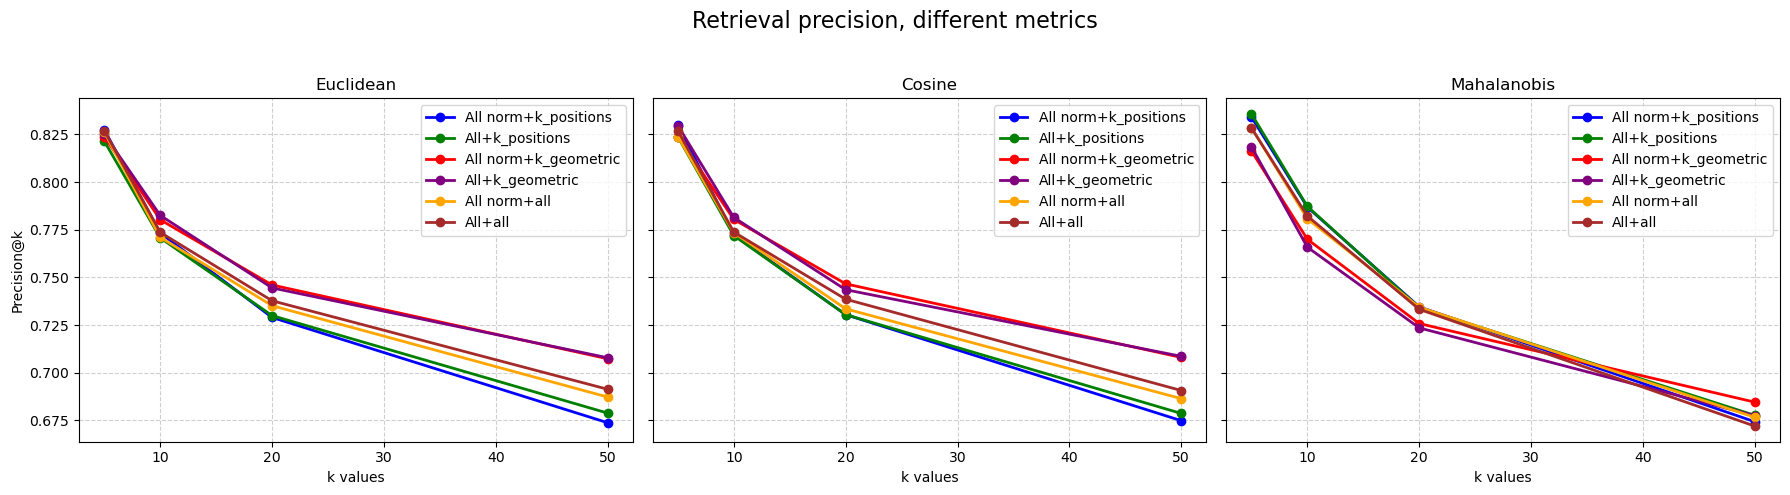

In [14]:
import matplotlib.pyplot as plt
figsize = (18, 5)

fig, axes = plt.subplots(1, 3, figsize=figsize, sharey=True)

metrics = ["Euclidean", "Cosine", "Mahalanobis"]
all_scores = [precision_scores_euclidean, precision_scores_cosine, precision_scores_mahalanobis]
colors = ["blue", "green", "red", "purple", "orange", "brown"]

for ax, metric, scores in zip(axes, metrics, all_scores):
    for score, label, color in zip(scores.values(), scores.keys(), colors):
        ax.plot(k_values, score, marker="o", color=color, linewidth=2, label=label)
    ax.set_title(metric)
    ax.set_xlabel("k values")
    ax.grid(True, linestyle="--", alpha=0.6)
    if ax == axes[0]:
        ax.set_ylabel("Precision@k")
    ax.legend()

plt.suptitle("Retrieval precision, different metrics", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

/var/folders/1b/yw3k2nwd14gfcn_47x1fkm6r0000gn/T/ipykernel_72773/2577316995.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scores.keys(), rotation=45, ha="right")
/var/folders/1b/yw3k2nwd14gfcn_47x1fkm6r0000gn/T/ipykernel_72773/2577316995.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scores.keys(), rotation=45, ha="right")
/var/folders/1b/yw3k2nwd14gfcn_47x1fkm6r0000gn/T/ipykernel_72773/2577316995.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scores.keys(), rotation=45, ha="right")


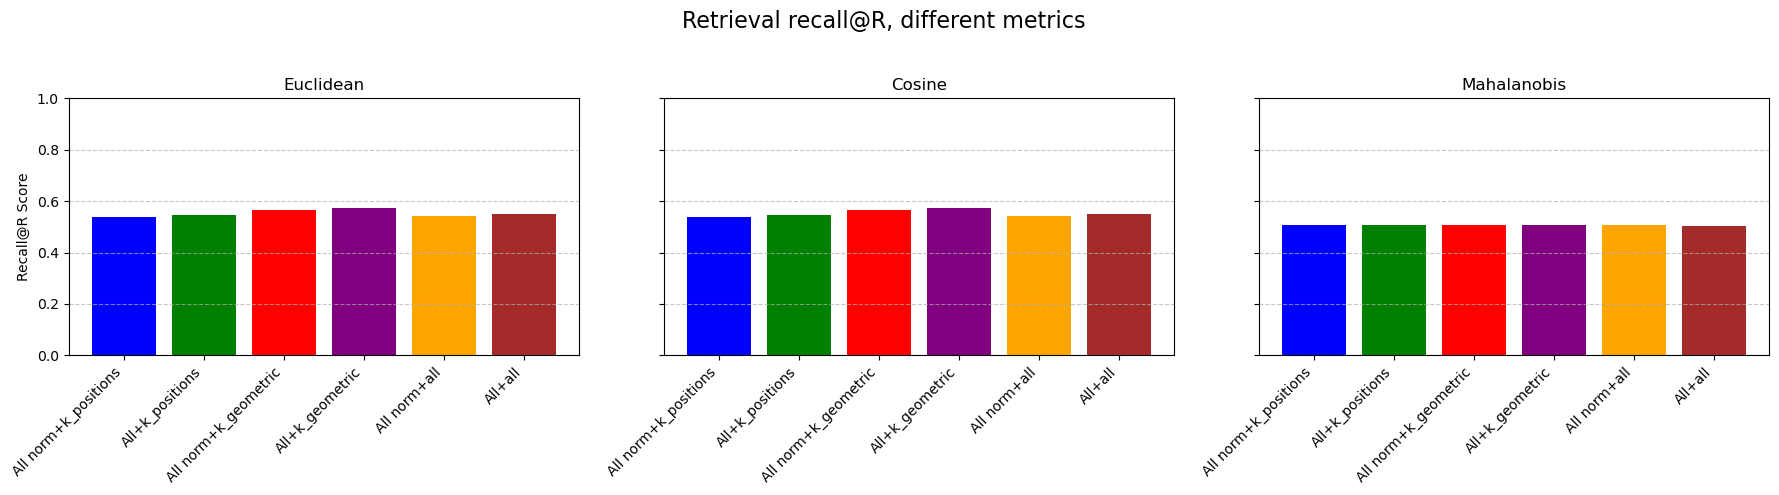

In [16]:
figsize = (18, 5)
fig, axes = plt.subplots(1, 3, figsize=figsize, sharey=True)

metrics = ["Euclidean", "Cosine", "Mahalanobis"]
all_scores = [recall_scores_euclidean, recall_scores_cosine, recall_scores_mahalanobis]
colors = ["blue", "green", "red", "purple", "orange", "brown"]

for ax, metric, scores in zip(axes, metrics, all_scores):
    ax.bar(scores.keys(), scores.values(), color=colors[:len(scores)])
    ax.set_title(metric)
    ax.set_ylabel("Recall@R Score" if ax == axes[0] else "")
    ax.set_xticklabels(scores.keys(), rotation=45, ha="right")
    ax.set_ylim(0, 1)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.suptitle("Retrieval recall@R, different metrics", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


/var/folders/1b/yw3k2nwd14gfcn_47x1fkm6r0000gn/T/ipykernel_72773/3324743758.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scores.keys(), rotation=45, ha="right")
/var/folders/1b/yw3k2nwd14gfcn_47x1fkm6r0000gn/T/ipykernel_72773/3324743758.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scores.keys(), rotation=45, ha="right")
/var/folders/1b/yw3k2nwd14gfcn_47x1fkm6r0000gn/T/ipykernel_72773/3324743758.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scores.keys(), rotation=45, ha="right")


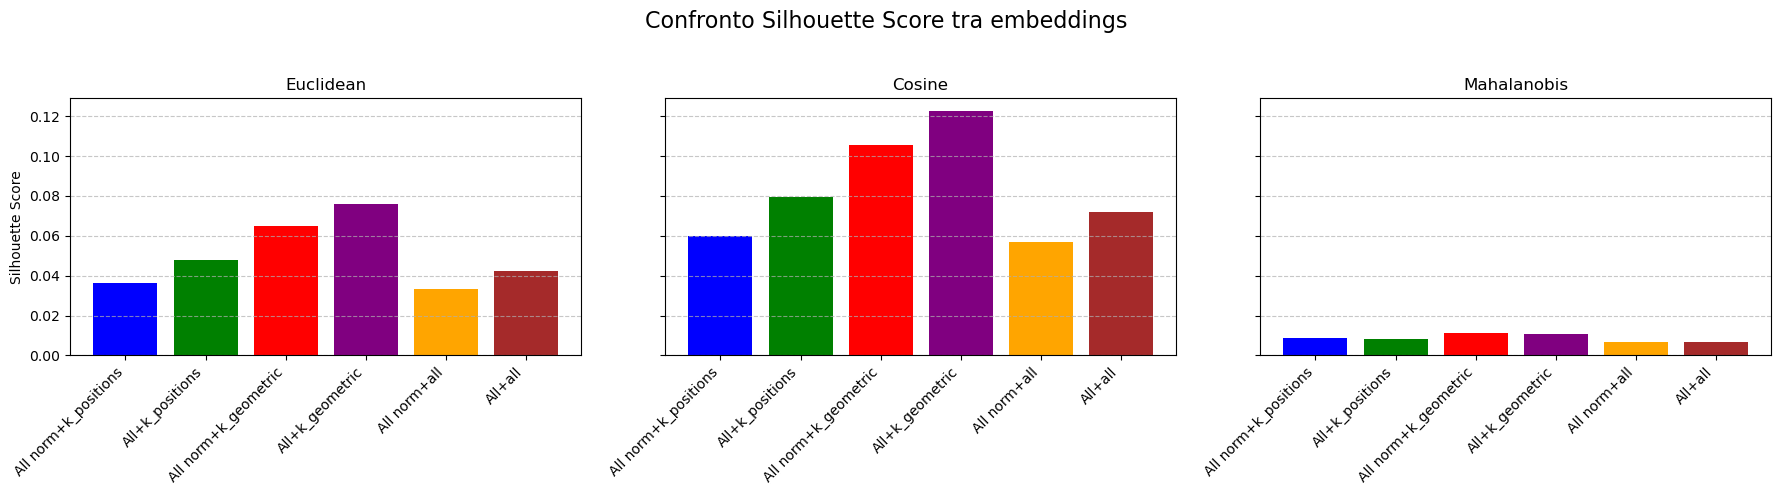

In [17]:
figsize = (18, 5)
fig, axes = plt.subplots(1, 3, figsize=figsize, sharey=True)

metrics = ["Euclidean", "Cosine", "Mahalanobis"]
all_scores = [silhouette_scores_euclidean, silhouette_scores_cosine, silhouette_scores_mahalanobis]
colors = ["blue", "green", "red", "purple", "orange", "brown"]

for ax, metric, scores in zip(axes, metrics, all_scores):
    ax.bar(scores.keys(), scores.values(), color=colors[:len(scores)])
    ax.set_title(metric)
    ax.set_ylabel("Silhouette Score" if ax == axes[0] else "")
    ax.set_xticklabels(scores.keys(), rotation=45, ha="right")
    #ax.set_ylim(-1, 1)  # Silhouette score range
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.suptitle("Confronto Silhouette Score tra embeddings", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


**Compare embeddings according to visual image similarity**

In [18]:
image_paths = emb_builder.image_paths
idx_query = 98
image_to_retrieve = image_paths[idx_query]

print("Image to retrieve")
img = mpimg.imread(image_to_retrieve)
plt.figure(figsize=(3, 3))
plt.imshow(img)
plt.axis('off')
plt.show()

for name, retrieval in retrieval_euclidean.items():
    print(f"{name}".ljust(100, "-"))
    distances_all, image_paths_similar_all = retrieval.retrieve_similar(idx_query=idx_query,k=5,verbose=False)
    retrieval.show_images(image_paths_similar_all)

Image to retrieve


FileNotFoundError: [Errno 2] No such file or directory: '79_JPG_jpg.rf.e0a22ce35886276cd57e85fe5874523e.jpg'

**Classifier training with different embeddings**

In [174]:
embeddings_classifiers = {name : Classifier(emb, emb_builder.y, emb_builder.classes_bs) for name, emb in zip(embeddings_names, embeddings)}

In [175]:
clf = RandomForestClassifier(n_estimators=300,
                max_depth=8,              # limit tree depth
                min_samples_split=10,     # require more samples to split
                min_samples_leaf=5,       # require more samples per leaf
                max_features="sqrt",      # random feature selection
                bootstrap=True,
                random_state=42)

learning_scores = { name: classifier.plot_learning_curve(clf, verbose = False) for name, classifier in embeddings_classifiers.items()}
print("Learning scores evaluated successfully!")

Learning scores evaluated successfully!


In [19]:
figsize = (embeddings_classifiers["All norm+k_positions"].figsize[0]*2, embeddings_classifiers["All norm+k_positions"].figsize[1]*2)
colors = ["blue", "green", "red", "brown", "yellow", "fuchsia"]

plt.figure(figsize=figsize)
for score, label, color in zip(learning_scores.values(), learning_scores.keys(), colors):
    plt.plot(score[0], score[3], marker="o", color=color, linewidth=2, label=label)
    #plt.plot(score[0], score[4], marker="o", color=color, linewidth=2, label=label) test curve
    plt.plot(score[0][len(score[0])-1], score[4][len(score[4])-1], marker="x",markersize = 10, color=color)

# Legenda
plt.legend(
    loc="center left",          # posizione di riferimento
    bbox_to_anchor=(1, 0.5),    # sposta la legenda a destra del grafico
    fontsize=10
)
plt.xlabel("k values")
plt.ylabel("Accuracy")
plt.title("Learning curves with different embeddings")
plt.grid(True)
plt.show()

NameError: name 'embeddings_classifiers' is not defined

In [ ]:
save_as_pdf(ipynbname.path())